# Test on a RGB star

In [1]:
import sys
sys.path.append('/home/oliver/PhD/Hacks_and_Mocks/')
import lightkurve as lk
import warnings
warnings.filterwarnings('ignore')
print(lk.__version__)

1.1.dev


In [2]:
datalist = lk.search_lightcurvefile('KIC11615890')
data = datalist.download_all()
lc = data[0].PDCSAP_FLUX.normalize().flatten()
for nlc in data[0:4]:
    lc = lc.append(nlc.PDCSAP_FLUX.normalize().flatten())
lc = lc.remove_nans()
pg = lc.to_periodogram(normalization='psd')
snr = pg.flatten()

Our value for numax is: 153.14 uHz
Our value for numax is: 13.15 uHz


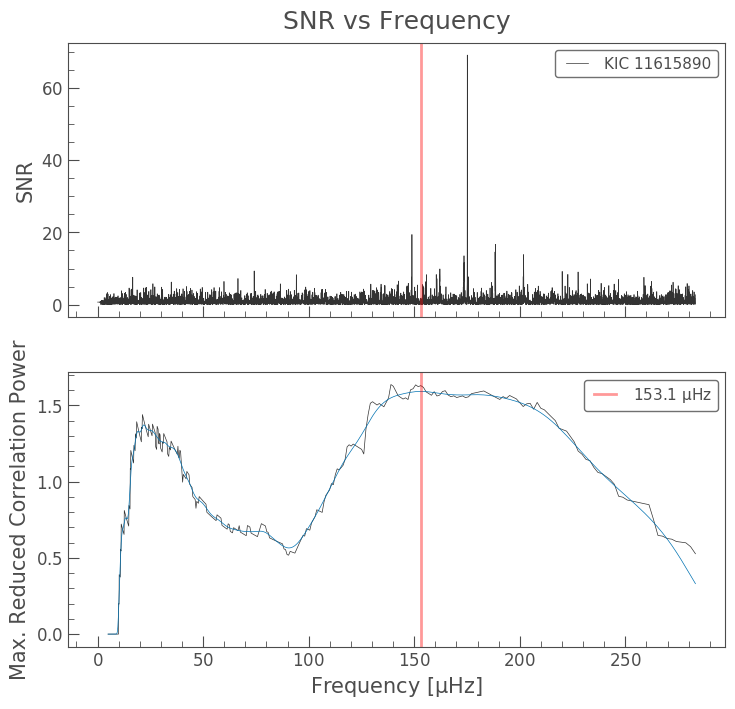

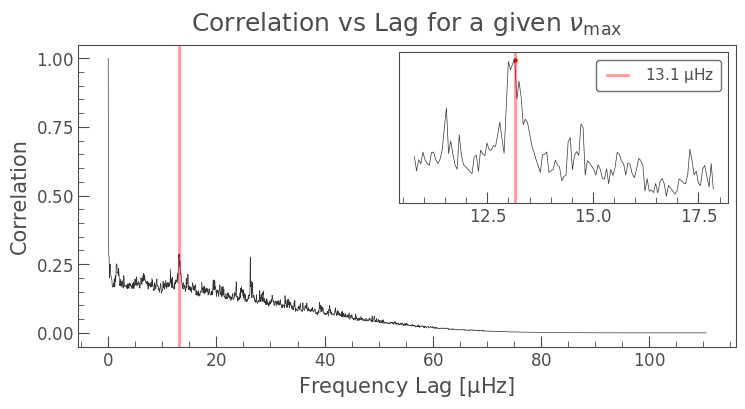

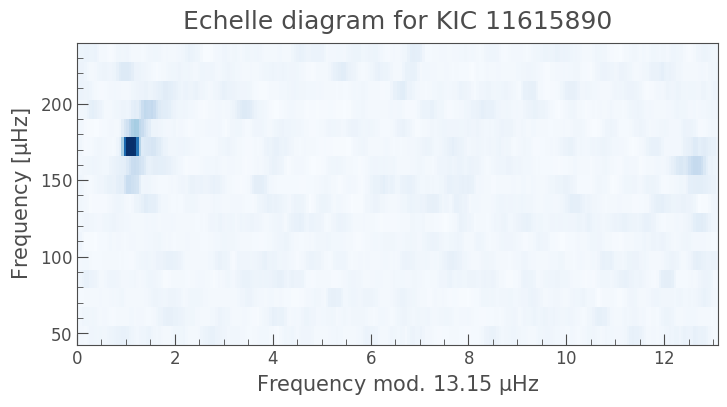

In [3]:
numax, ax = snr.estimate_numax(show_plots=True)
print('Our value for numax is: {:.2f}'.format(numax))
dnu, ax = snr.estimate_dnu(show_plots=True)
print('Our value for numax is: {:.2f}'.format(dnu))
snr.smooth(filter_width=.3).plot_echelle(dnu, numax)

# Test on a MS Star

In [4]:
datalist = lk.search_lightcurvefile('16CygA',cadence='short')
data = datalist[3:4].download_all()
lc = data[0].PDCSAP_FLUX.normalize().flatten()
for nlc in data:
    lc = lc.append(nlc.PDCSAP_FLUX.normalize().flatten())
lc = lc.remove_nans()
pg = lc.to_periodogram(normalization='psd')
snr = pg.flatten()

Our value for numax is: 2124.31 uHz
Our value for numax is: 103.41 uHz


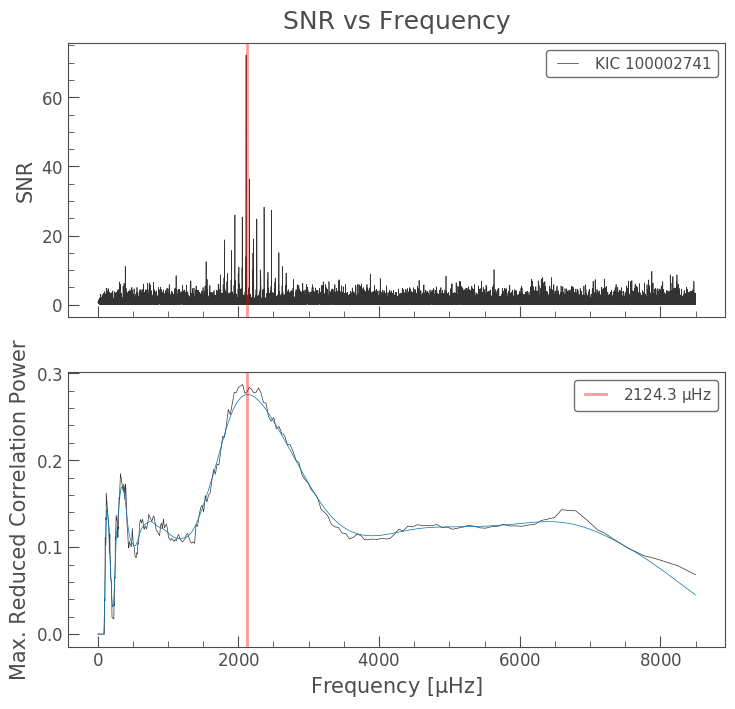

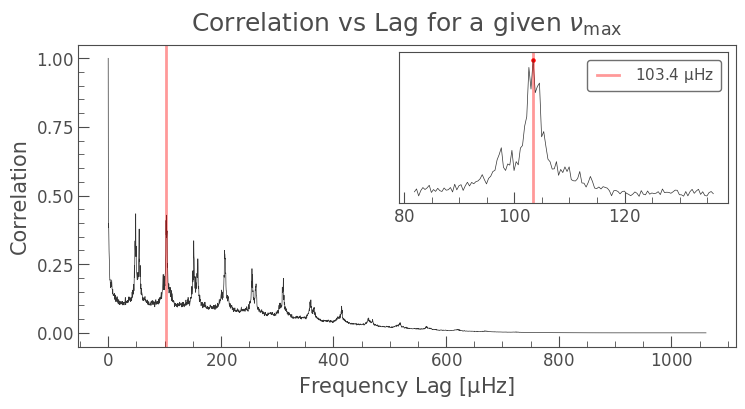

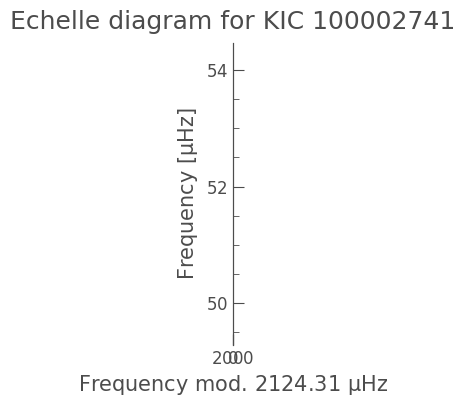

In [5]:
numax, ax = snr.estimate_numax(show_plots=True)
print('Our value for numax is: {:.2f}'.format(numax))
dnu, ax = snr.estimate_dnu(show_plots=True)
print('Our value for numax is: {:.2f}'.format(dnu))
snr.plot_echelle(numax, dnu)